In [2]:
#import Regression_variables from same directory
from Regression_variables import *
# from sklearn.model_selection import cross_val_score

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

# compounds is the name of the data frame

KeyboardInterrupt: 

# Creating Random Forests for Random, Strat, Hierarchical clustering, UMAP noise and UMAP furthest cluster splits

In [2]:
rfr_rand = RandomForestRegressor(random_state=SEED)
rfr_strat = RandomForestRegressor(random_state=SEED)
rfr_hi = RandomForestRegressor(random_state=SEED)
rfr_noise = RandomForestRegressor(random_state=SEED)
rfr_fur = RandomForestRegressor(random_state=SEED)

rfr_rand.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
rfr_strat.fit(np.array(list((x_train_strat))).astype(float), y_train_strat)
rfr_hi.fit(np.array(list((x_train_hi))).astype(float), y_train_hi)
rfr_noise.fit(np.array(list((x_train_noise))).astype(float), y_train_noise)
rfr_fur.fit(np.array(list((x_train_fur))).astype(float), y_train_fur)

y_pred_rfr_rand = rfr_rand.predict(np.array(list((x_test_rand))).astype(float))
y_pred_rfr_strat = rfr_strat.predict(np.array(list((x_test_strat))).astype(float))
y_pred_rfr_hi = rfr_hi.predict(np.array(list((x_test_hi))).astype(float))
y_pred_rfr_noise = rfr_noise.predict(np.array(list((x_test_noise))).astype(float))
y_pred_rfr_fur = rfr_fur.predict(np.array(list((x_test_fur))).astype(float))

mae_rfr_rand = mean_absolute_error(y_test_rand, y_pred_rfr_rand)
mse_rfr_rand = mean_squared_error(y_test_rand, y_pred_rfr_rand)
r2_rfr_rand = r2_score(y_test_rand, y_pred_rfr_rand)

mae_rfr_strat = mean_absolute_error(y_test_strat, y_pred_rfr_strat)
mse_rfr_strat = mean_squared_error(y_test_strat, y_pred_rfr_strat)
r2_rfr_strat = r2_score(y_test_strat, y_pred_rfr_strat)

mae_rfr_hi = mean_absolute_error(y_test_hi, y_pred_rfr_hi)
mse_rfr_hi = mean_squared_error(y_test_hi, y_pred_rfr_hi)
r2_rfr_hi = r2_score(y_test_hi, y_pred_rfr_hi)

mae_rfr_noise = mean_absolute_error(y_test_noise, y_pred_rfr_noise)
mse_rfr_noise = mean_squared_error(y_test_noise, y_pred_rfr_noise)
r2_rfr_noise = r2_score(y_test_noise, y_pred_rfr_noise)

mae_rfr_fur = mean_absolute_error(y_test_fur, y_pred_rfr_fur)
mse_rfr_fur = mean_squared_error(y_test_fur, y_pred_rfr_fur)
r2_rfr_fur = r2_score(y_test_fur, y_pred_rfr_fur)

In [3]:
#Create a table that shows the performance of the random forest regressor on the different splits displaying mae, mse and r2 values
#display and save variable values to 3sf

split_scores_rfr_initial = {'Split': ['Random', 'Stratified pIC50', 'Hierarchical Clustering', 'UMAP Noise', 'UMAP Furthest Cluster'],
        'MAE': [mae_rfr_rand, mae_rfr_strat, mae_rfr_hi, mae_rfr_noise, mae_rfr_fur],
        'MSE': [mse_rfr_rand, mse_rfr_strat, mse_rfr_hi, mse_rfr_noise, mse_rfr_fur],
        'R2': [r2_rfr_rand, r2_rfr_strat, r2_rfr_hi, r2_rfr_noise, r2_rfr_fur]}

split_scores_rfr_initial_df = pd.DataFrame(split_scores_rfr_initial)
split_scores_rfr_initial_df.set_index("Split", inplace=True)
# Round the values to 3 significant figures
split_scores_rfr_initial_df = split_scores_rfr_initial_df.applymap(lambda x: round(x, 3))
#save df to csv in data file
split_scores_rfr_initial_df.to_csv(DATA / "split_scores_rfr_initial.csv")
print(split_scores_rfr_initial_df)

                           MAE    MSE     R2
Split                                       
Random                   0.383  0.309  0.580
Stratified pIC50         0.462  0.423  0.517
Hierarchical Clustering  0.675  0.705  0.324
UMAP Noise               0.782  0.836 -0.050
UMAP Furthest Cluster    0.839  0.939 -0.238


# Optuna

### With a saving feature

In [4]:
# Create a study with SQLite storage
study_name = "random_forest_study"  # Unique identifier of the study
storage_name = f"sqlite:///example.db"  # SQLite database URL

study_name_TPE = "random_forest_study_TPE"  # Unique identifier of the study
storage_name_TPE = f"sqlite:///example_TPE.db"  # SQLite database URL

study_rand = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
study_rand_TPE = optuna.create_study(study_name=study_name_TPE, storage=storage_name_TPE, load_if_exists=True)

[I 2024-08-02 14:56:25,548] Using an existing study with name 'random_forest_study' instead of creating a new one.
[I 2024-08-02 14:56:25,605] Using an existing study with name 'random_forest_study_TPE' instead of creating a new one.


In [5]:
def objective(trial, X_train, y_train):
    n_estimators = trial.suggest_int("n_estimators", 50, 750)
    max_depth = trial.suggest_int("max_depth", 4, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [6]:
def save_best_trial(study, trial):
    if study.best_trial == trial:
        print(f"New best trial found: {trial.number}")
        print(f"Value: {trial.value}")
        print(f"Params: {trial.params}")


In [7]:
# Create study without saving best trials

# study_rand = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_strat = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_hi = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_noise = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_fur = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))

#set the sampler of this study to genetic aglorithm
# study_rand_TPE = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))


In [8]:
# study_rand.optimize(lambda trial: objective(trial, np.array(list((x_train_rand))).astype(float), y_train_rand), n_trials=1000, show_progress_bar=True)

# Optimize the study with a callback to save the best trial
study_rand.optimize(lambda trial: objective(trial, np.array(list(x_train_rand)).astype(float), y_train_rand), 
                    n_trials=1000, 
                    show_progress_bar=True, 
                    callbacks=[save_best_trial])


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-08-02 14:56:38,019] Trial 1038 finished with value: -0.5756810823695877 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 625 with value: -0.594897434492848.
[I 2024-08-02 14:56:40,921] Trial 1039 finished with value: -0.5808747038046658 and parameters: {'n_estimators': 77, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 625 with value: -0.594897434492848.
[I 2024-08-02 14:56:41,801] Trial 1040 finished with value: -0.5876471506458587 and parameters: {'n_estimators': 64, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 625 with value: -0.594897434492848.
[I 2024-08-02 14:56:44,404] Trial 1041 finished with value: -0.5791061637436608 and parameters: {'n_estimators': 87, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 625 with value: -0.594897434492848.
[I 2024-08-02 14:56:45,089] Trial 1042 finished with value: -0.558185770

In [9]:
study_rand_TPE.optimize(lambda trial: objective(trial, np.array(list(x_train_rand)).astype(float), y_train_rand), 
                    n_trials=1000, 
                    show_progress_bar=True, 
                    callbacks=[save_best_trial])

  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-08-02 15:13:24,946] Trial 2001 finished with value: -0.5852322192005464 and parameters: {'n_estimators': 83, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 312 with value: -0.5968716739648052.
[I 2024-08-02 15:13:27,701] Trial 2002 finished with value: -0.5778064529416959 and parameters: {'n_estimators': 324, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 312 with value: -0.5968716739648052.
[I 2024-08-02 15:13:29,250] Trial 2003 finished with value: -0.5379807593502117 and parameters: {'n_estimators': 126, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 312 with value: -0.5968716739648052.
[I 2024-08-02 15:13:30,028] Trial 2004 finished with value: -0.534770211214909 and parameters: {'n_estimators': 63, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 312 with value: -0.5968716739648052.
[I 2024-08-02 15:13:30,934] Trial 2005 finished with value: -0.5811

In [10]:
study_name_fur_TPE = "random_forest_study_fur_TPE"  # Unique identifier of the study
storage_name_fur_TPE = f"sqlite:///example_fur_TPE.db"  # SQLite database URL

study_fur_TPE = optuna.create_study(study_name=study_name_fur_TPE, storage=storage_name_fur_TPE, load_if_exists=True)
study_fur_TPE.optimize(lambda trial: objective(trial, np.array(list(x_train_fur)).astype(float), y_train_fur), 
                    n_trials=1000, 
                    show_progress_bar=True, 
                    callbacks=[save_best_trial])

[I 2024-08-02 15:31:39,675] Using an existing study with name 'random_forest_study_fur_TPE' instead of creating a new one.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-08-02 15:31:40,670] Trial 1168 finished with value: -1.1158892936942695 and parameters: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1168 with value: -1.1158892936942695.
New best trial found: 1168
Value: -1.1158892936942695
Params: {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 8}
[I 2024-08-02 15:31:41,096] Trial 1169 finished with value: -1.1534639838897138 and parameters: {'n_estimators': 65, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1169 with value: -1.1534639838897138.
New best trial found: 1169
Value: -1.1534639838897138
Params: {'n_estimators': 65, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8}
[I 2024-08-02 15:31:41,473] Trial 1170 finished with value: -1.1388597026658458 and parameters: {'n_estimators': 52, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 1169 with value: -1.1534639838897138.
[I 2024-0

In [ ]:
#add trials using study.optimize
# study_rand_TPE.optimize(lambda trial: objective(trial, np.array(list((x_train_rand))).astype(float), y_train_rand), n_trials=1000, show_progress_bar=True)
# study_strat.optimize(lambda trial: objective(trial, np.array(list((x_train_strat))).astype(float), y_train_strat), n_trials=200, show_progress_bar=True)
# study_hi.optimize(lambda trial: objective(trial, np.array(list((x_train_hi))).astype(float), y_train_hi), n_trials=200, show_progress_bar=True)
# study_noise.optimize(lambda trial: objective(trial, np.array(list((x_train_noise))).astype(float), y_train_noise), n_trials=200, show_progress_bar=True)
# study_fur.optimize(lambda trial: objective(trial, np.array(list((x_train_fur))).astype(float), y_train_fur), n_trials=200, show_progress_bar=True)



In [1]:
study_rand.best_params

NameError: name 'study_rand' is not defined

In [ ]:
study_rand_TPE.best_params

{'n_estimators': 50,
 'max_depth': 4,
 'min_samples_split': 8,
 'min_samples_leaf': 10}

In [ ]:
study_fur_TPE.best_params

{'n_estimators': 84,
 'max_depth': 7,
 'min_samples_split': 5,
 'min_samples_leaf': 10}

In [ ]:
best_params_rand = study_rand.best_params
best_params_rand_TPE = study_rand_TPE.best_params
best_params_fur = study_fur_TPE.best_params

# Using data from Optuna to create new RFR models

### Best sampler: Random

In [ ]:
# best_n_estimators_rand = best_params_rand["n_estimators"]
# best_max_depth_rand = best_params_rand["max_depth"]
# best_min_samples_split_rand = best_params_rand["min_samples_split"]
# best_min_samples_leaf_rand = best_params_rand["min_samples_leaf"]

best_n_estimators_rand = 50
best_max_depth_rand = 4
best_min_samples_split_rand = 6
best_min_samples_leaf_rand = 10

rfr_rand_best = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand, max_depth=best_max_depth_rand, min_samples_split=best_min_samples_split_rand, min_samples_leaf=best_min_samples_leaf_rand)
rfr_rand_best.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
y_pred_rfr_rand_best = rfr_rand_best.predict(np.array(list((x_test_rand))).astype(float))

mae_rfr_rand_best= mean_absolute_error(y_test_rand, y_pred_rfr_rand_best)
mse_rfr_rand_best= mean_squared_error(y_test_rand, y_pred_rfr_rand_best)
r2_rfr_rand_best = r2_score(y_test_rand, y_pred_rfr_rand_best)


NameError: name 'RandomForestRegressor' is not defined

### Best sampler: TPE

In [ ]:

# best_n_estimators_rand_TPE = best_params_rand_TPE["n_estimators"]
# best_max_depth_rand_TPE = best_params_rand_TPE["max_depth"]
# best_min_samples_split_rand_TPE = best_params_rand_TPE["min_samples_split"]
# best_min_samples_leaf_rand_TPE = best_params_rand_TPE["min_samples_leaf"]

best_n_estimators_rand_TPE = 50
best_max_depth_rand_TPE = 4
best_min_samples_split_rand_TPE = 8
best_min_samples_leaf_rand_TPE = 10

rfr_rand_best_TPE = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_rand_TPE, max_depth=best_max_depth_rand_TPE, min_samples_split=best_min_samples_split_rand_TPE, min_samples_leaf=best_min_samples_leaf_rand_TPE)
rfr_rand_best_TPE.fit(np.array(list((x_train_rand))).astype(float), y_train_rand)
y_pred_rfr_rand_best_TPE = rfr_rand_best_TPE.predict(np.array(list((x_test_rand))).astype(float))

mae_rfr_rand_best_TPE = mean_absolute_error(y_test_rand, y_pred_rfr_rand_best_TPE)
mse_rfr_rand_best_TPE = mean_squared_error(y_test_rand, y_pred_rfr_rand_best_TPE)
r2_rfr_rand_best_TPE = r2_score(y_test_rand, y_pred_rfr_rand_best_TPE)


In [ ]:
best_n_estimators_fur = 84
best_max_depth_fur = 7
best_min_samples_split_fur = 5
best_min_samples_leaf_fur = 10

rfr_fur_best = RandomForestRegressor(random_state=SEED, n_estimators=best_n_estimators_fur, max_depth=best_max_depth_fur, min_samples_split=best_min_samples_split_fur, min_samples_leaf=best_min_samples_leaf_fur)
rfr_fur_best.fit(np.array(list((x_train_fur))).astype(float), y_train_fur)
y_pred_rfr_fur_best = rfr_fur_best.predict(np.array(list((x_test_fur))).astype(float))

mae_rfr_fur_best= mean_absolute_error(y_test_fur, y_pred_rfr_fur_best)
mse_rfr_fur_best= mean_squared_error(y_test_fur, y_pred_rfr_fur_best)
r2_rfr_fur_best = r2_score(y_test_fur, y_pred_rfr_fur_best)

In [ ]:
#Create a table that shows the performance of the random forest regressor on the different splits displaying mae, mse and r2 values
split_scores_rfr_best = {'Split': ['Random', 'Random (Sampler: Random)', 'Random (Sampler: TPE)', 'Stratified pIC50', 'Hierarchical Clustering', 'UMAP Noise', 'UMAP Furthest Cluster', 'UMAP Furthest Cluster (Sampler: TPE)'],
        'MAE': [mae_rfr_rand, mae_rfr_rand_best, mae_rfr_rand_best_TPE, mae_rfr_strat, mae_rfr_hi, mae_rfr_noise, mae_rfr_fur, mae_rfr_fur_best],
        'MSE': [mse_rfr_rand, mse_rfr_rand_best, mse_rfr_rand_best_TPE, mse_rfr_strat, mse_rfr_hi, mse_rfr_noise, mse_rfr_fur, mse_rfr_fur_best],
        'R2': [r2_rfr_rand, r2_rfr_rand_best, r2_rfr_rand_best_TPE, r2_rfr_strat, r2_rfr_hi, r2_rfr_noise, r2_rfr_fur, r2_rfr_fur_best]}

split_scores_rfr_best_df = pd.DataFrame(split_scores_rfr_best)
split_scores_rfr_best_df.set_index("Split", inplace=True)
split_scores_rfr_best_df = split_scores_rfr_best_df.applymap(lambda x: round(x, 3))
#save df to csv in data file
split_scores_rfr_best_df.to_csv(DATA / "split_scores_rfr_best.csv")
print(split_scores_rfr_best_df)

                                           MAE       MSE        R2
Split                                                             
Random                                0.382970  0.309122  0.579999
Random (Sampler: Random)              0.570227  0.471628  0.359203
Random (Sampler: TPE)                 0.570227  0.471628  0.359203
Stratified pIC50                      0.461976  0.423172  0.516725
Hierarchical Clustering               0.674829  0.705286  0.323519
UMAP Noise                            0.814169  0.897039 -0.124043
UMAP Furthest Cluster                 0.945847  1.173660 -0.598261
UMAP Furthest Cluster (Sampler: TPE)  0.981163  1.263040 -0.719976


In [ ]:
print(f"Random Split, Sampler: Random \n {study_rand.best_params}")
print(f"Random Split, Sampler: TPE \n {study_rand_TPE.best_params}")
print(f"Furthest Cluster Split, Sampler: TPE \n {study_fur_TPE.best_params}")
# study_rand_TPE.best_params

NameError: name 'study_rand' is not defined

# Plots

### Best parameters found by Optuna:
##### n_estimators = 323
##### max_depth = 8
##### min_samples_split = 2
##### min_samples_leaf = 1

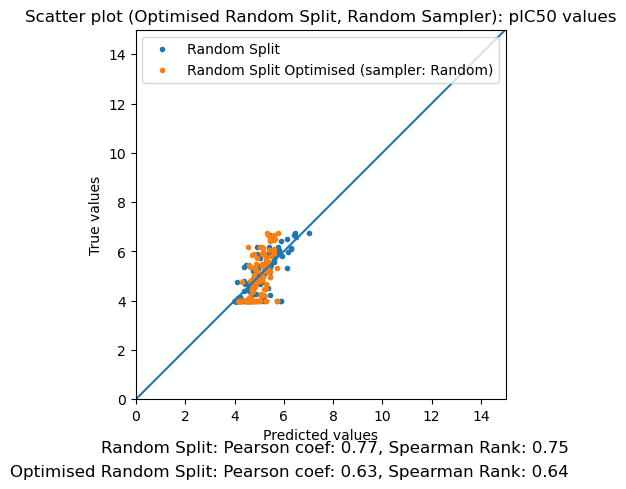

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rfr_rand, y_test_rand, marker="x", label="Random Split")
ax.scatter(y_pred_rfr_rand_best, y_test_rand, marker="x", label="Random Split Optimised (sampler: Random)")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised Random Split, Random Sampler): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)

pearsoncoef_rfr_rand = np.corrcoef(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand= spearmanr(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten()).correlation
pearsoncoef_rfr_rand_best = np.corrcoef(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand_best = spearmanr(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten()).correlation

fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_rand:.2f}, Spearman Rank: {spearmancoef_rfr_rand:.2f}", horizontalalignment='right', fontsize=12)
fig.text(0.9, -0.05, f"Optimised Random Split: Pearson coef: {pearsoncoef_rfr_rand_best:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best:.2f}", horizontalalignment='right', fontsize=12)
# save figure to DATA 
fig.savefig(DATA / "scatter_plot_rfr_rand.png")

ax.legend()
plt.show();

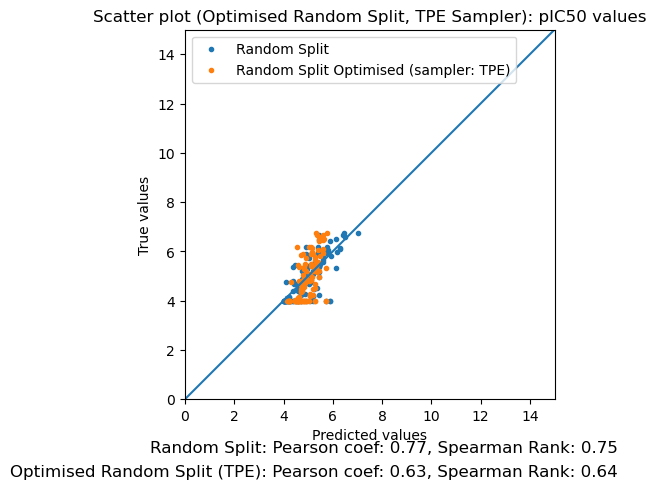

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rfr_rand, y_test_rand, marker="x", label="Random Split")
ax.scatter(y_pred_rfr_rand_best_TPE, y_test_rand, marker="x", label="Random Split Optimised (sampler: TPE)")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised Random Split, TPE Sampler): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)

pearsoncoef_rfr_rand_best_TPE= np.corrcoef(y_pred_rfr_rand_best_TPE.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand_best_TPE = spearmanr(y_pred_rfr_rand_best_TPE.flatten(), y_test_rand.values.flatten()).correlation
pearsoncoef_rfr_rand = np.corrcoef(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand = spearmanr(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten()).correlation
fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_rand:.2f}, Spearman Rank: {spearmancoef_rfr_rand:.2f}", horizontalalignment='right', fontsize=12)
fig.text(0.9, -0.05, f"Optimised Random Split (TPE): Pearson coef: {pearsoncoef_rfr_rand_best_TPE:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best_TPE:.2f}", horizontalalignment='right', fontsize=12)

fig.savefig(DATA / "scatter_plot_rfr_TPE.png")
ax.legend()
plt.show();

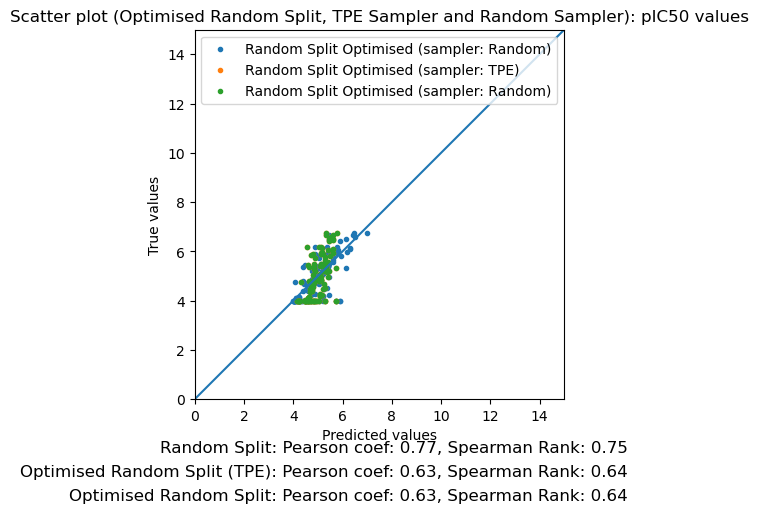

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rfr_rand, y_test_rand, marker="x", label="Random Split Optimised (sampler: Random)")
ax.scatter(y_pred_rfr_rand_best_TPE, y_test_rand, marker="x", label="Random Split Optimised (sampler: TPE)")
ax.scatter(y_pred_rfr_rand_best, y_test_rand, marker="x", label="Random Split Optimised (sampler: Random)")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised Random Split, TPE Sampler and Random Sampler): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)


pearsoncoef_rfr_rand_best_TPE= np.corrcoef(y_pred_rfr_rand_best_TPE.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand_best_TPE = spearmanr(y_pred_rfr_rand_best_TPE.flatten(), y_test_rand.values.flatten()).correlation
pearsoncoef_rfr_rand = np.corrcoef(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand = spearmanr(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten()).correlation
pearsoncoef_rfr_rand_best = np.corrcoef(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_rand_best = spearmanr(y_pred_rfr_rand_best.flatten(), y_test_rand.values.flatten()).correlation

fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_rand:.2f}, Spearman Rank: {spearmancoef_rfr_rand:.2f}", horizontalalignment='right', fontsize=12)
fig.text(0.9, -0.05, f"Optimised Random Split (TPE): Pearson coef: {pearsoncoef_rfr_rand_best_TPE:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best_TPE:.2f}", horizontalalignment='right', fontsize=12)
fig.text(0.9, -0.10, f"Optimised Random Split: Pearson coef: {pearsoncoef_rfr_rand_best:.2f}, Spearman Rank: {spearmancoef_rfr_rand_best:.2f}", horizontalalignment='right', fontsize=12)

fig.savefig(DATA / "scatter_plot_rfr_TPE_rand.png")
ax.legend()
plt.show();

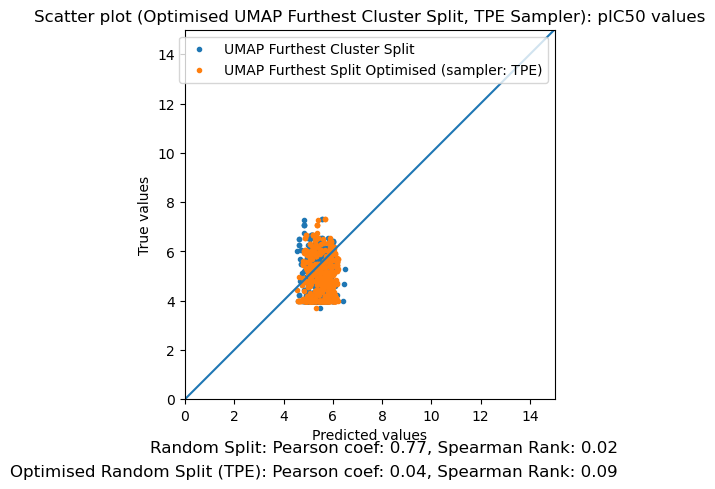

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rfr_fur, y_test_fur, marker="x", label="UMAP Furthest Cluster Split")
ax.scatter(y_pred_rfr_fur_best, y_test_fur, marker="x", label="UMAP Furthest Split Optimised (sampler: TPE)")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised UMAP Furthest Cluster Split, TPE Sampler): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)

pearsoncoef_rfr_fur_best_TPE = np.corrcoef(y_pred_rfr_fur_best.flatten(), y_test_fur.values.flatten())[0,1]
spearmancoef_rfr_fur_best_TPE = spearmanr(y_pred_rfr_fur_best.flatten(), y_test_fur.values.flatten()).correlation
pearsoncoef_rfr_fur = np.corrcoef(y_pred_rfr_rand.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rfr_fur = spearmanr(y_pred_rfr_fur.flatten(), y_test_fur.values.flatten()).correlation
fig.text(0.9, 0, f"Random Split: Pearson coef: {pearsoncoef_rfr_fur:.2f}, Spearman Rank: {spearmancoef_rfr_fur:.2f}", horizontalalignment='right', fontsize=12)
fig.text(0.9, -0.05, f"Optimised Random Split (TPE): Pearson coef: {pearsoncoef_rfr_fur_best_TPE:.2f}, Spearman Rank: {spearmancoef_rfr_fur_best_TPE:.2f}", horizontalalignment='right', fontsize=12)

fig.savefig(DATA / "scatter_plot_rfr_fur_TPE.png")
ax.legend()
plt.show();

In [ ]:
# optuna.visualization.plot_optimization_history(study_rand)
# optuna.visualization.plot_parallel_coordinate(study_rand)
# optuna.visualization.plot_slice(study_rand, params=["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"])
# optuna.visualization.plot_param_importances(study_rand)